## Fitting EPileptor 2D model (a slow-fast system in Numpyro)

### Set-up

In [1]:
import os
import sys
import time
import errno
import time
import timeit
import numpy as np
import scipy as scp
import seaborn as sns
import arviz as az

In [2]:
import numba
from numba import jit

In [3]:
import jax
import jax.numpy as jnp
from jax import random
from jax import grad, vmap, lax, random

from functools import partial
from jax.experimental.ode import odeint


import numpyro
from numpyro import sample, plate
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [4]:
print(f"Numpy version: {np.__version__}")
print(f"Numba version: {numba.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")
print(f"SciPy version: {scp.__version__}")
print(f"Arviz version: {az.__version__}")

Numpy version: 1.23.5
Numba version: 0.58.1
JAX version: 0.4.8
Numpyro version: 0.11.0
SciPy version: 1.10.1
Arviz version: 0.15.1


In [5]:
%pylab inline
#%matplotlib notebook

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sample', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
plt.style.use('seaborn-talk');
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

<ipython-input-6-e60eee76f3e8>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk');


In [7]:
import warnings
import yaml

warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)
yaml.warnings({'YAMLLoadWarning': False})

In [8]:
Res_dir=''

In [9]:
cwd = os.getcwd()
print("The results directory is:", cwd)

The results directory is: /Users/Meysam/WORK2/CurrentWork_codes/Epileptor


### Simulator

In [10]:
@jit(nopython=True)
def Epileptor_ODEmodel(params, constants, dt, ts):
   
    eta  = params[0]

    
    # fixed parameters
    tau0, I1, x_init, z_init=constants[0], constants[1], constants[2], constants[3]
        
        
    # simulation from initial point
    x = np.zeros_like(ts)  # fast voltage
    z = np.zeros_like(ts)  # slow voltage

    nt=int(ts.shape[0])
    
    x[0] = float(x_init)    
    z[0] = float(z_init) 
    
    for i in range(1, nt):
        dx =1.0 - x[i-1]**3 - 2.0*x[i-1]**2 - z[i-1] + I1   
        dz =(1.0/tau0)*(4*(x[i-1]-eta) - z[i-1])
        x[i]=(x[i-1] + dt * dx)
        z[i]=(z[i-1] + dt * dz)
        
    return x

In [11]:
#Epileptor_ODEmodel_numba = numba.jit(Epileptor_ODEmodel)

In [12]:
T = 100.0
dt=0.01
ts = np.arange(0, T + dt, dt)

In [13]:
nt=int(ts.shape[0])
nt

10001

In [14]:
eta=-1.5

params=np.array([eta])
params

array([-1.5])

In [15]:
tau0=10
I1=3.1

x_init=-2.5
z_init=3.5

constants = np.array([tau0, I1, x_init, z_init])

In [16]:
start_time = time.time()

x_jit=Epileptor_ODEmodel(params, constants, dt, ts)

print("similations took (sec):" , (time.time() - start_time))

similations took (sec): 0.6121327877044678


In [17]:
start_time = time.time()

x_jit=Epileptor_ODEmodel(params, constants, dt, ts)

print("similations using Numba's JIT took (sec):" , (time.time() - start_time))

similations using Numba's JIT took (sec): 0.00022983551025390625


In [18]:
ts.shape, x_jit.shape

((10001,), (10001,))

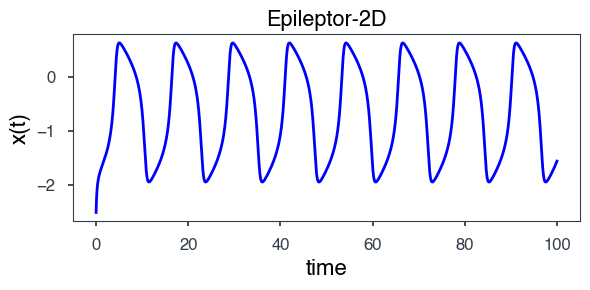

In [19]:
plt.figure(figsize=(6,3))
plt.plot(ts, x_jit,'-', color='b', lw=2);
plt.title('Epileptor-2D')
plt.ylabel('x(t)', fontsize=16); 
plt.xlabel('time', fontsize=16); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();
plt.show()

### Model Inversion in Numpyro using NUTS

First lets figure out which simuator is opt for Numpyro in jax.

In [20]:
from jax import random
rng_key = random.PRNGKey(0)

In [21]:
import jax.numpy as jnp
from jax import jit, vmap, lax, random

One way is to use JAX's JIT, and lax.scan (to convert the aboove Numba's JIT model to Jax (can we do it with vmap?)

In [22]:
@jit
def Epileptor_ODEmodel_JAXJIT(params, constants, dt, ts):
    
    key = jax.random.PRNGKey(0)
    
    eta  = params[0]

    
    # Fixed parameters
    tau0, I1, x_init, z_init=constants[0], constants[1], constants[2], constants[3]

    
    def update(carry, i):
        x, z = carry
        dx = 1.0 - x**3 - 2.0*x**2 - z + I1
        dz = (1.0 / tau0) * (4*(x - eta) - z)
        x = x + dt * dx #+ jnp.sqrt(dt) * sigma * random.normal(key=key)
        z = z + dt * dz #+ jnp.sqrt(dt) * sigma * random.normal(key=key)
        return (x, z), (x, z)

    nsteps=int(ts.shape[0])
    
    init_carry = (x_init, z_init)
    _, (x, z) = lax.scan(update, init_carry, jnp.arange(nsteps))
    
    return x

In [23]:
start_time = time.time()

x_jax=Epileptor_ODEmodel_JAXJIT(params, constants, dt, ts)

print("similations took (sec):" , (time.time() - start_time))

similations took (sec): 0.06796097755432129


In [24]:
start_time = time.time()

x_jax=Epileptor_ODEmodel_JAXJIT(params, constants, dt, ts)

print("similations using JAX JIT took (sec):" , (time.time() - start_time))

similations using JAX JIT took (sec): 0.0007700920104980469


Here we can use diffrax

In [25]:
from diffrax import diffeqsolve, Dopri5, ODETerm, Kvaerno5, Tsit5, SaveAt, PIDController

In [26]:
def Epileptor_vector_field(ts, state, args):
    x, z = state
    eta  = args
    tau0, I1=constants[0], constants[1]

    dx = 1.0 - x**3 - 2.0*x**2 - z + I1 
    dz =(1.0/tau0)*(4*(x-eta) - z)
    dy = dx, dz
    return dy

In [27]:
term = ODETerm(Epileptor_vector_field)
solver = Tsit5()

In [28]:
@jit
def Epileptor_ODEmodel_JAX_diffrax(params, constants, dt, ts):
    
    t0 = 0
    T = 100
    dt = 0.1
    
    tau0, I1, x_init, z_init=constants[0], constants[1], constants[2], constants[3]

    nt=nt=int(ts.shape[0])

    y0 = (x_init, z_init)
    
    args = params[0]
    
    saveat = SaveAt(ts=jnp.linspace(t0, T, nt))
    
    sol = diffeqsolve(term, solver, t0, T, dt, y0, args=args, saveat=saveat)
    
    x=sol.ys[0]
    
    return x

In [29]:
start_time = time.time()

x_diffrax=Epileptor_ODEmodel_JAX_diffrax(params, constants, dt, ts)

print("similations took using diffrax (sec):" , (time.time() - start_time))

similations took using diffrax (sec): 0.6855390071868896


In [30]:
start_time = time.time()

x_diffrax=Epileptor_ODEmodel_JAX_diffrax(params, constants, dt, ts)

print("similations took using JIT and diffrax (sec):" , (time.time() - start_time))

similations took using JIT and diffrax (sec): 0.0010638236999511719


Now lets use JAX's odeint

In [31]:
def Epileptor_vector_field(state, t, params):
  x, z= state
  eta=params
  return jnp.array([1.0 - x**3 - 2.0*x**2 - z + I1, (1.0/tau0)*(4*(x-eta) - z)])

In [32]:
def odeint_euler(f, y0, t, *args):
  def step(state, t):
    y_prev, t_prev = state
    dt = t - t_prev
    y = y_prev + dt * f(y_prev, t_prev, *args)
    return (y, t), y
  _, ys = lax.scan(step, (y0, t[0]), t[0:])
    
  return ys

In [33]:
def odeint_rk4(f, y0, t, *args):
  def step(state, t):
    y_prev, t_prev = state
    h = t - t_prev
    k1 = h * f(y_prev, t_prev, *args)
    k2 = h * f(y_prev + k1/2., t_prev + h/2., *args)
    k3 = h * f(y_prev + k2/2., t_prev + h/2., *args)
    k4 = h * f(y_prev + k3, t + h, *args)
    y = y_prev + 1./6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return (y, t), y
  _, ys = lax.scan(step, (y0, t[0]), t[0:])
  return ys

In [34]:
start_time = time.time()

ys_partial = odeint(partial(Epileptor_vector_field, params=eta), y0=jnp.array([x_init, z_init]), t=ts)

print("similations took using Partial odeint (sec):" , (time.time() - start_time))

similations took using Partial odeint (sec): 0.3818521499633789


In [35]:
start_time = time.time()

ys_euler = odeint_euler(Epileptor_vector_field, jnp.array([x_init, z_init]), ts, eta)

print("similations took using Euler odeint (sec):" , (time.time() - start_time))

similations took using Euler odeint (sec): 0.05893301963806152


In [36]:
start_time = time.time()

ys_rk4 = odeint_rk4(Epileptor_vector_field, jnp.array([x_init, z_init]), ts, eta)

print("similations took using RK4 odeint (sec):" , (time.time() - start_time))

similations took using RK4 odeint (sec): 0.11915898323059082


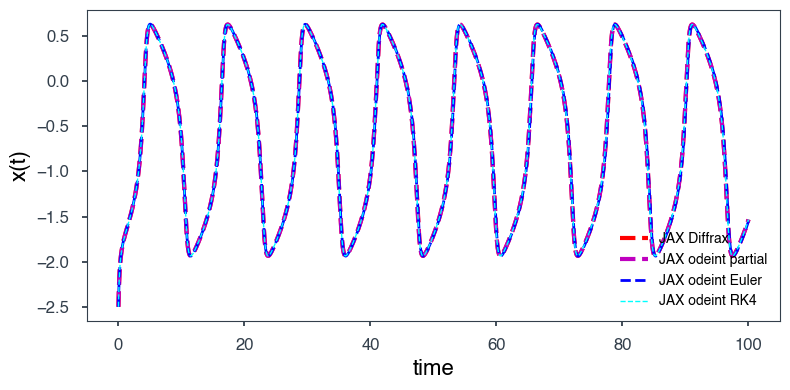

In [37]:
plt.figure(figsize=(8,4))
plt.plot(ts, x_diffrax,'--', color='red', lw=3, label='JAX Diffrax');
plt.plot(ts, ys_partial[:,0],'--', color='m', lw=3, label='JAX odeint partial');
plt.plot(ts, ys_euler[:,0],'--', color='blue', lw=2, label='JAX odeint Euler');
plt.plot(ts, ys_rk4[:,0],'--', color='cyan', lw=1, label='JAX odeint RK4');
plt.legend(fontsize=10, frameon=False, loc='lower right')
plt.ylabel('x(t)', fontsize=16); 
plt.xlabel('time', fontsize=16); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();
plt.show()

But don't worry! we put JAX's JIT on Odeint!

In [38]:
@jit
def Epileptor_ODEmodel_JAXOdeint(params, constants, dt, ts):
    
    tau0, I1, x_init, z_init=constants[0], constants[1], constants[2], constants[3]

    #ys_partial = odeint(partial(Epileptor_vector_field, params=params[0]), y0=jnp.array([x_init, z_init]), t=ts)
    #ys_euler = odeint_euler(Epileptor_vector_field, jnp.array([x_init, z_init]), ts, params[0])
    ys_rk4 = odeint_rk4(Epileptor_vector_field, jnp.array([x_init, z_init]), ts, params[0])
    
    x=ys_rk4[:,0]
    
    return x

In [39]:
start_time = time.time()

x_jax=Epileptor_ODEmodel_JAXOdeint(params, constants, dt, ts)

print("similations took (sec):" , (time.time() - start_time))

similations took (sec): 0.1398019790649414


In [40]:
start_time = time.time()

x_jax=Epileptor_ODEmodel_JAXOdeint(params, constants, dt, ts)

print("similations took (sec):" , (time.time() - start_time))

similations took (sec): 0.0014138221740722656


In [41]:
start_time = time.time()

x_jax=Epileptor_ODEmodel_JAXOdeint(params, constants, dt, ts)

print("similations usinf JAX JIT Odeint took (sec):" , (time.time() - start_time))

similations usinf JAX JIT Odeint took (sec): 0.0011591911315917969


In [42]:
ts.shape, x_jax.shape

((10001,), (10001,))

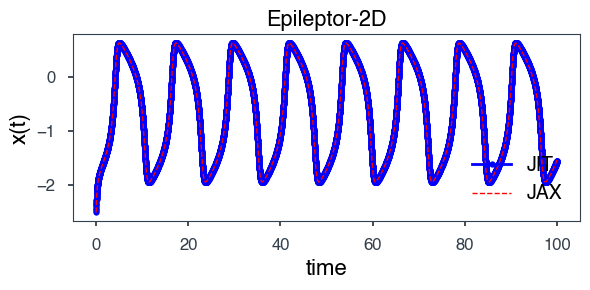

In [43]:
plt.figure(figsize=(6,3))
plt.plot(ts, x_jit,'.-', color='b', lw=2, label='JIT');
plt.plot(ts, x_jax,'--', color='r', lw=1, label='JAX');
plt.legend(fontsize=14, frameon=False, loc='lower right')
plt.title('Epileptor-2D')
plt.ylabel('x(t)', fontsize=16); 
plt.xlabel('time', fontsize=16); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();
plt.show()

### Observation

In [44]:
eta_true=-1.5

sigma_true=0.05

params_true=np.array([eta_true, sigma_true])
params_true

array([-1.5 ,  0.05])

In [45]:
x_jax=Epileptor_ODEmodel_JAXOdeint(params_true, constants, dt, ts)

In [46]:
x_noise = np.random.normal(loc=0, scale=sigma_true, size=x_jax.shape)

In [47]:
x_obs=x_jax+x_noise

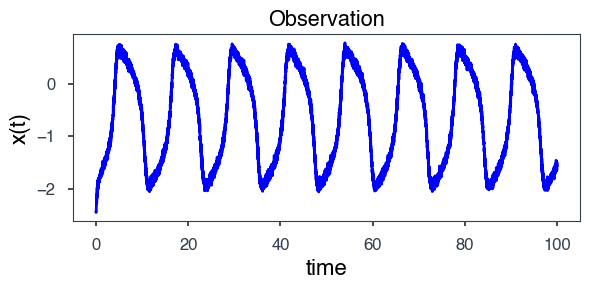

In [48]:
plt.figure(figsize=(6,3))
plt.plot(ts,x_obs,'-', color='b', lw=2);
plt.title('Observation')
plt.ylabel('x(t)', fontsize=16); 
plt.xlabel('time', fontsize=16); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();
plt.show()

In [49]:
nt=int(x_obs.shape[0])
nt

10001

In [50]:
ds=10
nt=int(x_obs[::ds].shape[0])
nt

1001

In [51]:
params_labels = [r'$\eta$', r'$\sigma$']

In [52]:
data= { 'nt': nt, 'ds': ds, 'ts': ts, 'dt': dt, 'constants': constants , 'x_obs': x_obs[::ds] }

In [53]:
data

{'nt': 1001,
 'ds': 10,
 'ts': array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.998e+01, 9.999e+01,
        1.000e+02]),
 'dt': 0.01,
 'constants': array([10. ,  3.1, -2.5,  3.5]),
 'x_obs': Array([-2.4390848, -2.1977499, -2.1094582, ..., -1.5858014, -1.64924  ,
        -1.5554199], dtype=float32)}

In [54]:
def model(data):
    #Data
    nt = data['nt']
    dt = data['dt']
    ts = data['ts']
    ds = data['ds']
    constants = data['constants']
    x_obs = data['x_obs']

    # Priors                
    eta_samples = numpyro.sample('eta_samples', dist.TruncatedNormal(high=-1.2, loc=-2.1, scale=.5))
    sigma_samples = numpyro.sample('sigma_samples',dist.TruncatedNormal(low=0.001, high=0.5, loc=0.1, scale=0.025))
    
    params_samples=[eta_samples, sigma_samples]
    
    x_hat=Epileptor_ODEmodel_JAXOdeint(params_samples, constants, dt, ts)[::ds]
        
    # Likelihood
    with plate('data', size=nt):
        x_hat = numpyro.deterministic('x_hat', x_hat)
        numpyro.sample('x_obs', dist.Normal(x_hat, sigma_samples), obs=x_obs)
        #numpyro.sample("x_obs", dist.LogNormal(jnp.log(x_hat), sigma_samples), obs=x_obs)

In [55]:
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key, data)

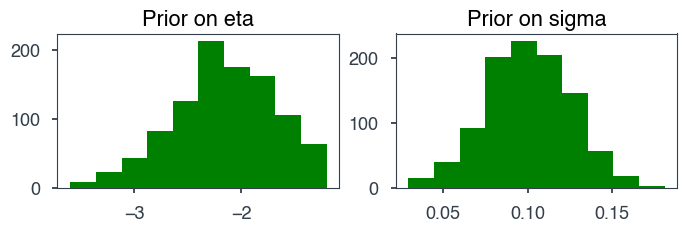

In [56]:
plt.figure(figsize=(8,2))
plt.subplot(121)
plt.hist(prior_predictions['eta_samples'], color='g');
plt.title('Prior on eta')
plt.subplot(122)
plt.hist(prior_predictions['sigma_samples'], color='g');
plt.title('Prior on sigma')
plt.show()

In [57]:
np.random.choice(prior_predictions['eta_samples'], 2)

array([-2.81577  , -2.0529337], dtype=float32)

In [58]:
n_=100
parasm_random=np.zeros((n_, 2))
parasm_random[:,0]=np.random.choice(prior_predictions['eta_samples'], 100)
parasm_random[:,1]=np.random.choice(prior_predictions['sigma_samples'], 100)

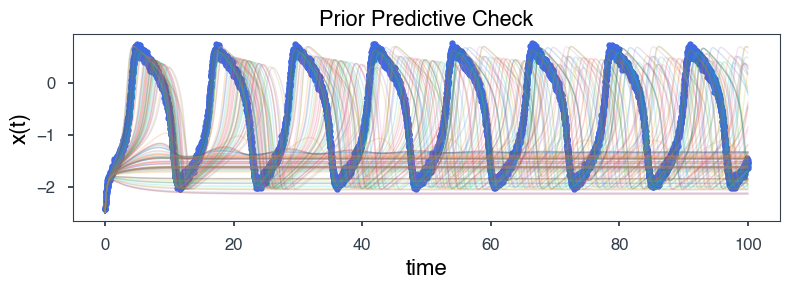

In [59]:
plt.figure(figsize=(8,3))
plt.plot(ts, x_obs,'.-', color='royalblue', lw=2, label='Observed', zorder=1);
for i in range(n_):
    x_priorcheck=Epileptor_ODEmodel_JAXOdeint(parasm_random[i,:], constants, dt, ts)
    plt.plot(ts, x_priorcheck, lw=1, alpha=0.2)
plt.title('Prior Predictive Check')
plt.ylabel('x(t)', fontsize=16); 
plt.xlabel('time', fontsize=16); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();
plt.show()    
plt.show()    

In [60]:
# NUTS set up
num_warmup, num_samples, num_chains = 2000, 2000, 4
kernel = NUTS(model, max_tree_depth=10, target_accept_prob=0.5, step_size=1,  adapt_step_size=True, )
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [61]:
#RUN NUTS
start_time = time.time()


mcmc.run(rng_key, data, extra_fields=('potential_energy',))

print(" MCMC using NUTS' Numpyro took (sec):" , (time.time() - start_time))


sample: 100%|██████████| 4000/4000 [00:15<00:00, 265.79it/s, 3 steps of size 1.22e+00. acc. prob=0.52]


 MCMC using NUTS' Numpyro took (sec): 67.06369090080261


In [62]:
mcmc.print_summary(exclude_deterministic=True)


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta_samples     -1.50      0.00     -1.50     -1.50     -1.50   5053.32      1.00
  sigma_samples      0.05      0.00      0.05      0.05      0.05   3403.33      1.00

Number of divergences: 0


In [63]:
lp = mcmc.get_extra_fields()['potential_energy']
print('Expected log joint density: {:.2f}'.format(np.mean(-lp)))

Expected log joint density: 1618.72


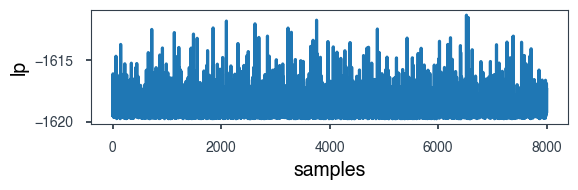

In [64]:
plt.figure(figsize=(6,2))
plt.plot(lp);
plt.ylabel('lp', fontsize=14); 
plt.xlabel('samples', fontsize=14); 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout();
plt.show()

In [65]:
# Get posterior samples
posterior_samples = mcmc.get_samples(group_by_chain=True)
pooled_posterior_samples = mcmc.get_samples()

In [66]:
pooled_posterior_samples

{'eta_samples': Array([-1.5004945, -1.4999495, -1.5007246, ..., -1.5012088, -1.5015903,
        -1.5018449], dtype=float32),
 'sigma_samples': Array([0.04719862, 0.04720715, 0.04910658, ..., 0.04788688, 0.04858961,
        0.04822793], dtype=float32),
 'x_hat': Array([[-2.5      , -2.237662 , -2.0926971, ..., -1.5762082, -1.5542712,
         -1.5316136],
        [-2.5      , -2.2376614, -2.092694 , ..., -1.5769503, -1.5550255,
         -1.5323818],
        [-2.5      , -2.2376628, -2.0926986, ..., -1.5759034, -1.5539613,
         -1.5312982],
        ...,
        [-2.5      , -2.2376633, -2.092701 , ..., -1.5752487, -1.5532957,
         -1.5306206],
        [-2.5      , -2.237664 , -2.0927033, ..., -1.5747364, -1.552775 ,
         -1.5300903],
        [-2.5      , -2.2376647, -2.092705 , ..., -1.574395 , -1.5524281,
         -1.529737 ]], dtype=float32)}

In [67]:
posterior_samples_keys = list(posterior_samples.keys())

posterior_samples_values = list(posterior_samples.values())

In [68]:
posterior_samples_keys

['eta_samples', 'sigma_samples', 'x_hat']

In [69]:
num_params=int(len(params_true))
num_params

2

In [70]:
posterior_samples['eta_samples'].shape, pooled_posterior_samples['eta_samples'].shape

((4, 2000), (8000,))

In [71]:
# Extract parameter values from posterior samples
eta_post = posterior_samples['eta_samples'].T
sigma_post = posterior_samples['sigma_samples'].T

In [72]:
eta_post.shape

(2000, 4)

In [73]:
params_posterior=np.array([eta_post,  sigma_post ])
params_posterior.shape

(2, 2000, 4)

In [74]:
colors = sns.color_palette("Blues", n_colors=num_chains)
colors_l = ["#A4C3D9", "#7B9DBF", "#52779F", "#2A537E"] 

In [75]:
params_meanest=np.percentile(params_posterior.reshape(num_params,-1).T, [50], axis=0).reshape(-1)
params_meanest

array([-1.5007087 ,  0.04793267])

Text(0.5, 0.98, 'HMC')

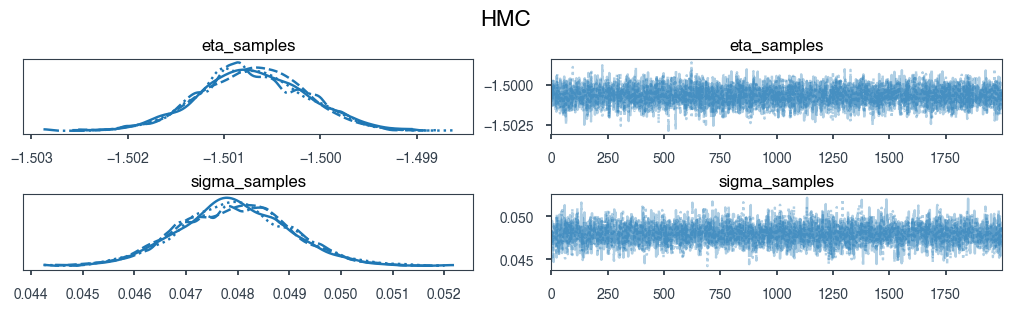

In [76]:
axes = az.plot_trace(
    az.from_numpyro(mcmc),
    var_names=['eta_samples', 'sigma_samples'],
    compact=True,
    kind="trace",
    backend_kwargs={"figsize": (10, 3), "layout": "constrained"},)

plt.gcf().suptitle("HMC", fontsize=16)

In [77]:
az.summary(az.from_numpyro(mcmc), var_names=['eta_samples', 'sigma_samples'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta_samples,-1.501,0.001,-1.502,-1.50,0.0,0.0,5052.0,5576.0,1.0
sigma_samples,0.048,0.001,0.046,0.05,0.0,0.0,3417.0,3674.0,1.0


In [78]:
pooled_posterior_predictive = Predictive(model=model, posterior_samples=pooled_posterior_samples)

In [79]:
rng_key, rng_subkey = random.split(key=rng_key)

In [80]:
pooled_posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, data)

In [81]:
pooled_idata = az.from_numpyro(posterior=mcmc, posterior_predictive=pooled_posterior_predictive_samples)

In [82]:
pooled_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

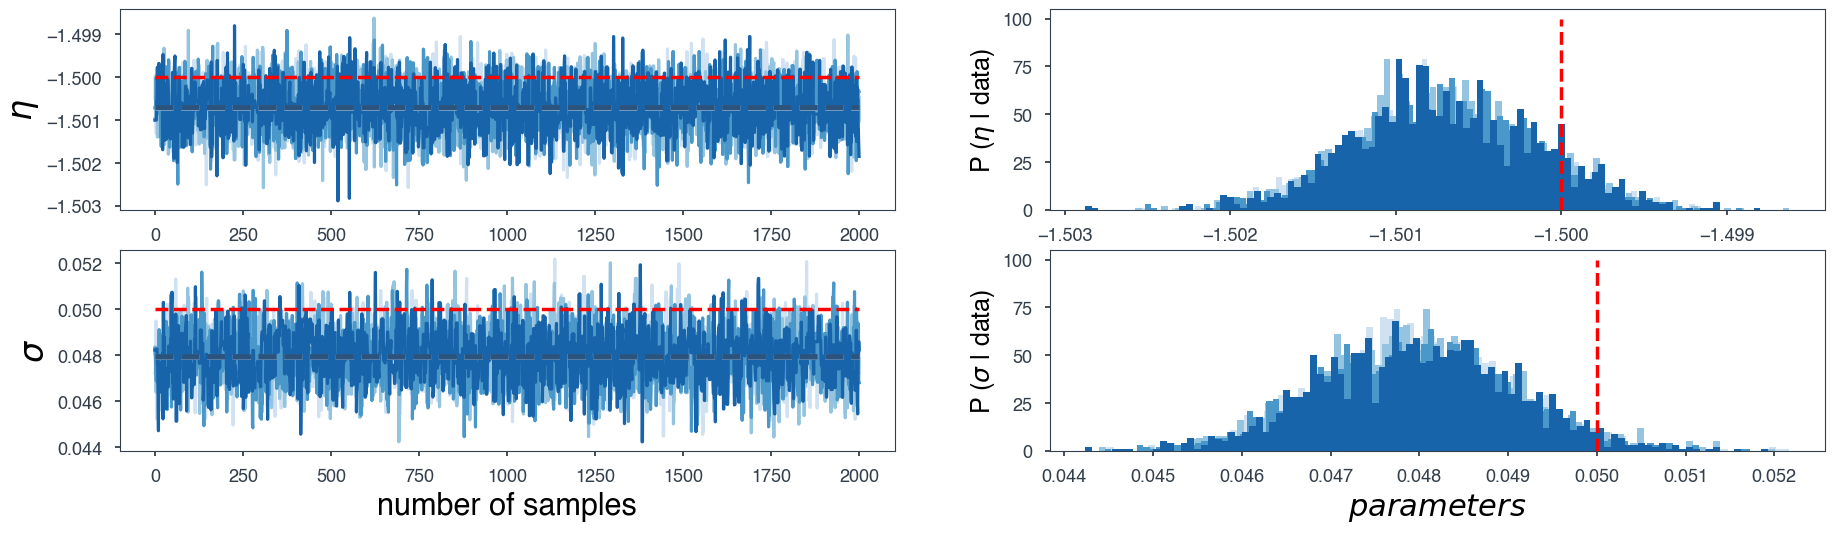

In [83]:
plt.figure(figsize=(22,12))
for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    for j in range(num_chains):
        plt.plot(params_posterior[i,:, j], color=colors[j])
        plt.hlines(y=np.mean(params_posterior[i,:, j]), xmin=0., xmax=num_samples, linewidth=3.5, color=colors_l[j], linestyle='--', zorder=10)
    plt.hlines(y=params_true[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(params_labels[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    for j in range(num_chains):
             plt.hist(params_posterior[i, :,j], bins=100, color=colors[j])
    plt.vlines(x=params_true[i], ymin=0., ymax=100, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('P ('+str(params_labels[i])+' | data)',  fontsize=18)
#plt.tight_layout();   
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_MCMC_obs1.png"), doi=800)
plt.show()

In [84]:
params_meanest

array([-1.5007087 ,  0.04793267])

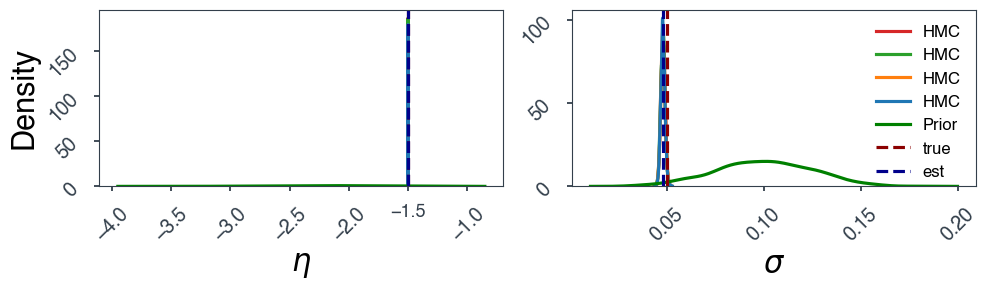

In [85]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
sns.kdeplot(eta_post, label='HMC')
sns.kdeplot(prior_predictions['eta_samples'], color='g', label='Prior');
plt.axvline(x = eta_true, color = 'darkred', linestyle='--', label='true')
plt.axvline(x = params_meanest[0], color = 'darkblue', linestyle='--', label='est')
plt.xlabel('$\eta$',  fontsize=22)
plt.ylabel('Density', fontsize=22)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14, rotation=45)
plt.legend('', frameon=False)

plt.subplot(122)
sns.kdeplot(sigma_post, label='HMC')
sns.kdeplot(prior_predictions['sigma_samples'], color='g', label='Prior');
plt.axvline(x = sigma_true, color = 'darkred', linestyle='--', label='true')
plt.axvline(x = params_meanest[1], color = 'darkblue', linestyle='--', label='est')
plt.xlabel('$\sigma$',  fontsize=22)
plt.ylabel('')
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14, rotation=45)
plt.legend(fontsize=12, frameon=False, loc='upper right')
plt.tight_layout();
plt.show()

In [86]:
params_posterior.shape

(2, 2000, 4)

In [87]:
params_posterior.reshape(num_chains,-1).T.shape

(4000, 4)

In [88]:
params_posterior.reshape(num_params,-1).T.shape, mean(params_posterior.reshape(num_params,-1).T, axis=1).T.shape

((8000, 2), (8000,))

In [89]:
params_posterior.reshape(num_params,-1).T

array([[-1.5004945 ,  0.04719862],
       [-1.5009581 ,  0.04805816],
       [-1.5007137 ,  0.04830309],
       ...,
       [-1.501014  ,  0.0478369 ],
       [-1.5003333 ,  0.04679304],
       [-1.5018449 ,  0.04822793]], dtype=float32)

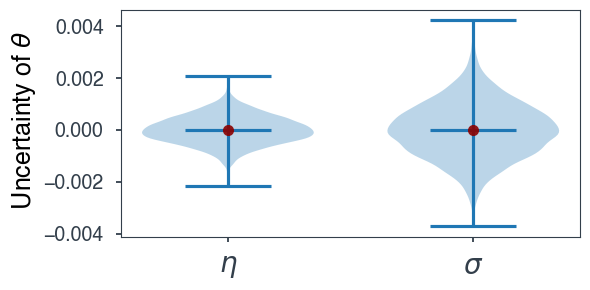

In [90]:
plt.figure(figsize=(6,3))
parts= plt.violinplot(params_posterior.reshape(num_params,-1).T-np.mean(params_posterior.reshape(num_params,-1).T, axis=0), widths=0.7, showmeans=True, showextrema=True);
plt.plot(np.r_[1:len(params_true)+1], params_true -params_true,'o', color='darkred', alpha=0.9, markersize=8)
plt.ylabel(' Uncertainty of ' +r'${\theta}$', fontsize=18);  
plt.xticks(np.r_[1:num_params+1], params_labels, rotation=0, fontsize=20)  
plt.yticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_violonplot_obs1.png"), dpi=800)
plt.show()

In [91]:
corr_vals=np.corrcoef(params_posterior.reshape(num_params,-1))

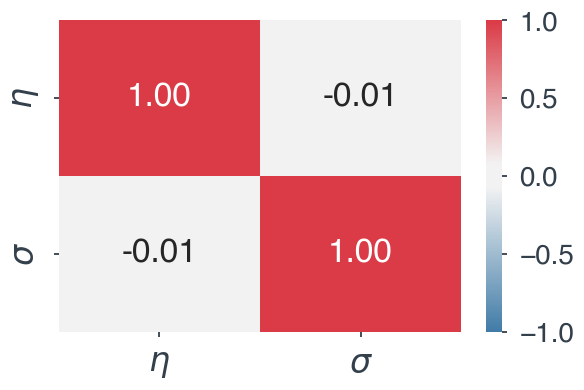

In [92]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
sns.heatmap(corr_vals, annot=True, robust=True, cmap=cmap, linewidths=.0, annot_kws={'size':24}, fmt=".2f", vmin=-1, vmax=1, ax=ax, xticklabels=params_labels, yticklabels=params_labels)
#ax.set_xticklabels()
#ax.set_yticklabels()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax.tick_params(labelsize=24)
plt.tight_layout()
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"corr_samples_obs1.png"), dpi=800)
plt.show()

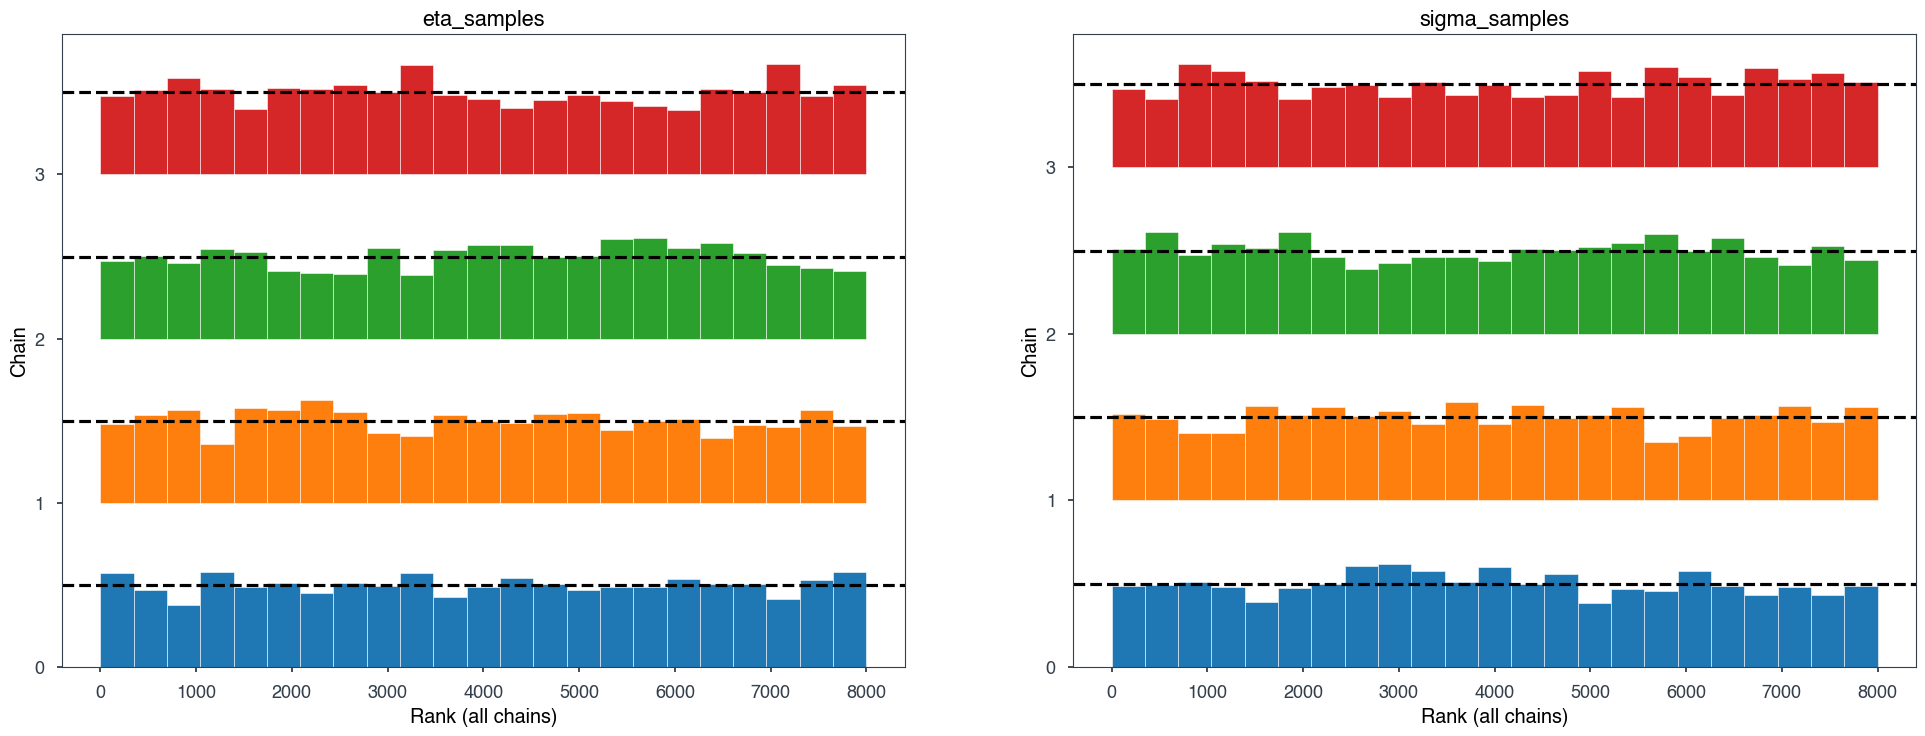

In [93]:
az.plot_rank(az.from_numpyro(mcmc), var_names=['eta_samples',  'sigma_samples'])
plt.show()

In [94]:
params_meanest=np.percentile(params_posterior.reshape(num_params,-1).T, [50], axis=0).reshape(-1)
params_meanest

array([-1.5007087 ,  0.04793267])

In [95]:
params_true

array([-1.5 ,  0.05])

In [96]:
RMSE=np.sqrt(np.mean((params_true-params_meanest)**2))
RMSE

0.0015453357739130132

In [97]:
pooled_posterior_samples['eta_samples'].shape

(8000,)

In [98]:
n_=100
parasm_random=np.zeros((n_, 2))
parasm_random[:,0]=np.random.choice(pooled_posterior_samples['eta_samples'], n_)
parasm_random[:,1]=np.random.choice(pooled_posterior_samples['sigma_samples'], n_)

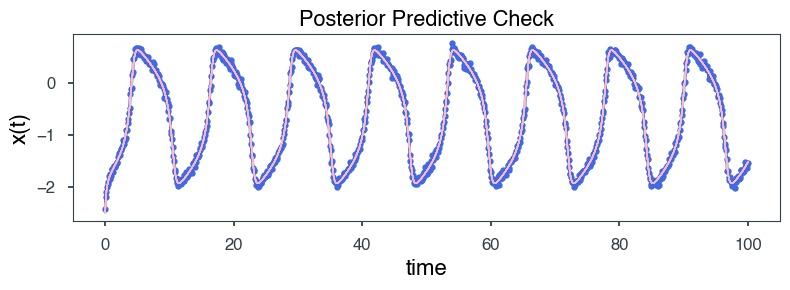

In [99]:
plt.figure(figsize=(8,3))
plt.plot(ts[::ds], x_obs[::ds],'.-', color='royalblue', lw=2, label='Observed', zorder=1);
for i in range(n_):
    x_ppc=Epileptor_ODEmodel_JAXOdeint(params_true, constants, dt, ts)
    plt.plot(ts, x_ppc, lw=1, color='pink', alpha=0.2)
plt.title('Posterior Predictive Check')
plt.ylabel('x(t)', fontsize=16); 
plt.xlabel('time', fontsize=16); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();
plt.show()    
plt.show()    

In [100]:
# Assuming you have your observed data in the `data` dictionary
predictive = Predictive(model, num_samples=1000)
ppc = predictive(rng_key, data)
ppc['eta_samples'].shape

(1000,)

In [101]:
params_posterior.shape

(2, 2000, 4)

In [102]:
np.percentile(params_posterior.reshape(num_params,-1).T, [50], axis=0).reshape(-1)

array([-1.5007087 ,  0.04793267])

In [103]:
x_fit_map=Epileptor_ODEmodel_JAXOdeint(params_meanest, constants, dt, ts)

In [104]:
x_ppc_lo=Epileptor_ODEmodel_JAXOdeint(np.percentile(params_posterior.reshape(num_params,-1).T, [5], axis=0).reshape(-1),  constants, dt, ts)
x_ppc_hi=Epileptor_ODEmodel_JAXOdeint(np.percentile(params_posterior.reshape(num_params,-1).T, [95], axis=0).reshape(-1),  constants, dt, ts)

In [105]:
x_fit_map.shape, x_obs.shape

((10001,), (10001,))

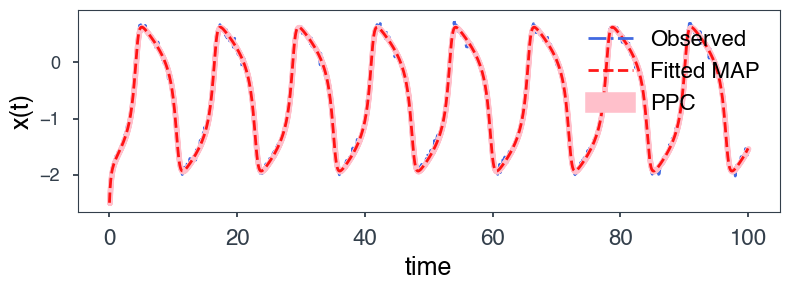

In [106]:
plt.figure(figsize=(8,3))
plt.plot(ts[::ds], x_obs[::ds],'-.', color='royalblue', lw=2, label='Observed', zorder=1);
plt.plot(ts[::ds], x_fit_map[::ds],'--', color='r', alpha=0.9,  lw=2, label='Fitted MAP', zorder=4);
plt.fill_between(ts, x_ppc_lo, x_ppc_hi, linewidth=4,facecolor='pink', edgecolor='pink', label='PPC', zorder=2)
plt.ylabel('x(t)', fontsize=18); 
plt.xlabel('time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16, frameon=False, loc='upper right')
plt.tight_layout();
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs1.png"), dpi=800)
plt.show()

In [107]:
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer import SVI, Trace_ELBO

from numpyro.infer.autoguide import AutoLaplaceApproximation

In [108]:
optimizer = numpyro.optim.Minimize()
optimizer = optim.Adam(step_size=.001)

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
init_state = svi.init(random.PRNGKey(0), data)

In [109]:
optimal_state, loss = svi.update(init_state, data)


In [110]:
params = svi.get_params(optimal_state)  # get guide's parameters
params

{'auto_loc': Array([0.22170252, 1.761747  ], dtype=float32)}

In [111]:
quantiles = guide.quantiles(params, 0.5)  # get means of posterior samples
quantiles

{'eta_samples': Array(-2.4482, dtype=float32),
 'sigma_samples': Array(0.42686072, dtype=float32),
 'x_hat': Array([-2.5      , -2.239198 , -2.0981295, ..., -1.6581852, -1.6581852,
        -1.6581852], dtype=float32)}

In [112]:
x_fit_svi=quantiles['x_hat']
x_fit_svi.shape

(1001,)

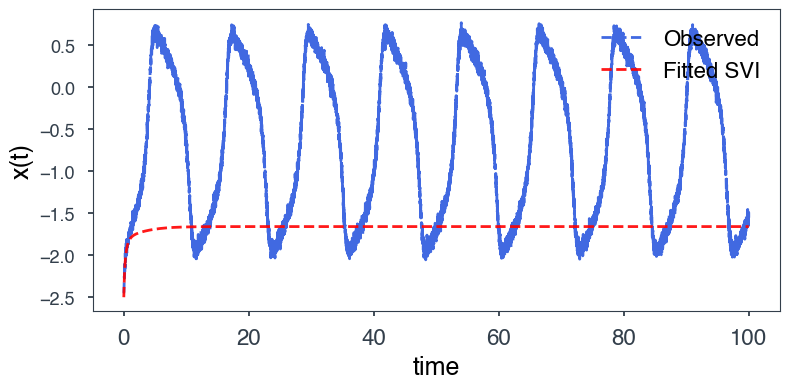

In [113]:
plt.figure(figsize=(8,4))
plt.plot(ts, x_obs,'--', color='royalblue', lw=2, label='Observed', zorder=1);
plt.plot(ts[::ds], x_fit_svi,'--', color='r', alpha=0.9,  lw=2, label='Fitted SVI', zorder=4);
plt.ylabel('x(t)', fontsize=18); 
plt.xlabel('time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16, frameon=False, loc='upper right')
plt.tight_layout();
#plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs1.png"), dpi=800)
plt.show()